In [9]:
import os
import pandas as pd
import numpy as np
import ROOT
import xgboost as xgb
import matplotlib.pyplot as plt
import argparse
from sklearn.preprocessing import QuantileTransformer
import pickle

trainVar=["ThirdLeptonPt", "SubleadingInvMass", "LeptonicWMass", "DimuonPt", "NCentralJets", "NJets_WP85", "CorrectFourthLeptonPt", "FourthThirdInvMass", "CorrectLeptonicTopMass", "HT", "CosThetaStar", "FirstBreitLikelihoodTopCandMass"]

#parser = argparse.ArgumentParser()
#parser.add_argument("-s","--sampleName",type=str,default="mc16a_344388")
#parser.add_argument("-m","--modelFolder",type=str,default="model_1")
#parser.add_argument("-v","--var",type=str,default="Var12")
#parser.add_argument("-o","--outFolder",type=str,default="ntuples")

print("hello")
#args = parser.parse_args()
print("hello")
#os.system("mkdir -vp %s/%s"%(args.outFolder, args.var))
os.system("mkdir -vp %s/%s"%("ntuples","Var12"))

do = True

print("hello")
## ========================================================================
## generate Quantile transformation pickle file
## =====================================================================
#qt_file = os.path.join(args.modelFolder, args.var, "transformer_"+args.sampleName+".pickle")
qt_file = "model_1/Var12/transformer_410218.pickle"
if do==True:
    print("== generate QT pickle ==")
    dVal={}
    quantile_transform = {}
    for fold in [1,2,3,4]:
        print("this is ", fold)
        #dFTest=pd.read_csv("/eos/home-z/zijia/Hmumu/tthmumustudies/mini_csv/fold_%d/%s_val.csv"%(fold,args.sampleName))
        dFTest=pd.read_csv("/eos/home-z/zijia/Hmumu/tthmumustudies/mini_csv/fold_%d/%s_val.csv"%(fold,"mc16a_410218"))
        #dFTest=pd.concat(dFTest,ignore_index=True)
        dVal[fold]=xgb.DMatrix(dFTest[trainVar],feature_names=trainVar)
        print(dVal[fold])

        Model=xgb.Booster()
        #Model.load_model("%s/%s/fold_%d.model"%(args.modelFolder, args.var, fold))
        Model.load_model("%s/%s/fold_%d.model"%("model_1","Var12",fold))

        raw_scores=Model.predict(dVal[fold])
        print(raw_scores)
        #print(np.array(raw_scores))
        #fig,ax=plt.subplots()
        #plt.hist(np.array(raw_scores), bins=25, color='mediumorchid',label="raw score")
        #plt.show()
        #fig.tight_layout()
        #fig.savefig("%s/%s/fold_%d_raw.pdf"%(args.modelFolder, args.var, fold))

        quantile_transform[fold] = QuantileTransformer()#n_quantiles=10000, subsample=1000000)
        quantile_transform[fold].fit(raw_scores.reshape(-1, 1))
    with open(qt_file, "wb") as f: pickle.dump(quantile_transform,f)
    print("== generated QT pickle as %s =="%(qt_file))


hello
hello
hello
== generate QT pickle ==
this is  1
[0.9999819  0.9999893  0.99999475 ... 0.9999616  0.99999535 0.9999958 ]
this is  2
[0.9999919  0.99963486 0.99998236 ... 0.9999969  0.9999901  0.99998236]
this is  3
[0.99999356 0.99999034 0.9999554  ... 0.99999666 0.999969   0.9999962 ]
this is  4
[0.9999924  0.9999918  0.99999595 ... 0.9999825  0.9999689  0.9999963 ]
== generated QT pickle as model_1/Var12/transformer_410218.pickle ==


this is  1
[0.05455456 0.1031031  0.33033034 ... 0.02748203 0.36436436 0.46996996]
[0.9999819  0.9999893  0.99999475 ... 0.9999616  0.99999535 0.9999958 ]


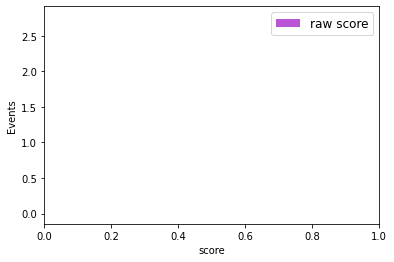

this is  2
[0.15865865 0.00207914 0.05805806 ... 0.9374374  0.11611611 0.05805806]
[0.9999919  0.99963486 0.99998236 ... 0.9999969  0.9999901  0.99998236]


this is  3
[0.1971972  0.11761761 0.02552553 ... 0.6316316  0.03703704 0.43443444]
[0.99999356 0.99999034 0.9999554  ... 0.99999666 0.999969   0.9999962 ]


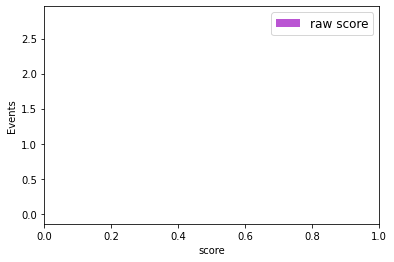

this is  4
[0.16466467 0.14764765 0.43193194 ... 0.05355356 0.03513514 0.6386386 ]
[0.9999924  0.9999918  0.99999595 ... 0.9999825  0.9999689  0.9999963 ]


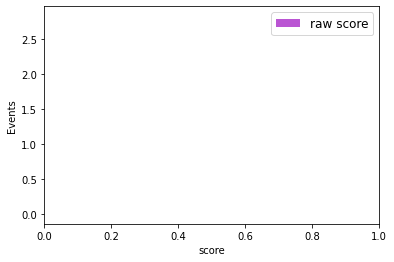

In [6]:
## ========================================================================
## apply scores and QT
## ========================================================================
#print("hello")
with open(qt_file, 'rb') as f: transformers = pickle.load(f)
dVal={}
for fold in [1,2,3,4]:
    print("this is ", fold)
    dFTest=pd.read_csv("/eos/home-z/zijia/Hmumu/tthmumustudies/mini_csv/fold_%d/%s_val.csv"%(fold,"mc16a_410218"))
    #dFTest=pd.concat(dFTest,ignore_index=True)
    dVal[fold]=xgb.DMatrix(dFTest[trainVar],feature_names=trainVar)

    Model=xgb.Booster()
    Model.load_model("%s/%s/fold_%d.model"%("model_1","Var12",fold))

    raw_scores=Model.predict(dVal[fold])
    #print(raw_scores.reshape(-1,1))
    #print(transformers[fold])
    transformed_scores = transformers[fold].transform(raw_scores.reshape(-1,1))
    #print("hello")
    scores = transformed_scores.reshape(1,-1)[0]
    print(scores)
    print(raw_scores)
    fig,ax=plt.subplots()
    plt.hist(np.array(raw_scores), bins=25, color='mediumorchid',label="raw score",weights=dFTest["Weight"]*dFTest["Weight_BTagSF85"])
    #plt.hist(np.array(scores), bins=25, color='cornflowerblue',label="QT score",weights=dFTest["Weight"]*dFTest["Weight_BTagSF85"])
    ax.set_xlim(0,1)
    #ax.set_ylim(0,1000)
    plt.xlabel("score")
    plt.ylabel("Events")
    ax.legend(fontsize='large')
    plt.rcParams["font.family"]="Arial"
    plt.show()
    fig.tight_layout()
    fig.savefig("%s/%s/fold_%d_QT.pdf"%("model_1","Var12",fold))
    
    #for iVar in trainVar:
    #    fig,ax=plt.subplots()
    #    plt.hist(dFTest[iVar], bins=20, color='k',label=iVar,weights=dFTest["Weight"]*dFTest["Weight_BTagSF85"])
    #    plt.xlabel(iVar)
    #    plt.ylabel("Events")
    #    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #    ax.text(0.05, 0.95, iVar, transform=ax.transAxes, fontsize=14, verticalalignment='top',position=(0.7,0.9), bbox=props)
    #    fig.tight_layout()
    #    plt.show()
    #    fig.savefig("%s/%s/fold_%d_%s.pdf"%("model_1","Var12",fold,iVar))